In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train_prepared = pd.read_csv('/content/drive/My Drive/Data Analytics/retail_kaggle_data/train_prepared.csv')

In [7]:
train_prepared.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,day_of_week
0,24,105574,2013-01-02,18790.0,12.0,True,2013,1,2,2
1,24,105574,2013-01-03,59692.0,1.0,True,2013,1,3,3
2,24,105574,2013-01-04,99664.0,3.0,True,2013,1,4,4
3,24,105574,2013-01-05,140805.0,4.0,True,2013,1,5,5
4,24,105574,2013-01-06,182800.0,7.0,True,2013,1,6,6


In [8]:
#filter for data before April 2014
train_prep_filtered = train_prepared[train_prepared['date'] < '2014-04-01']

In [49]:
#filter for a few items (i will choose top 5 most frequently bought)
most_frequent_items = train_prep_filtered.groupby('item_nbr')['unit_sales'].sum().sort_values(ascending=False).head(5).index
top_items_only = train_prep_filtered[train_prep_filtered['item_nbr'].isin(most_frequent_items)]

In [50]:
most_frequent_items

Index([257847, 839362, 215352, 315176, 364606], dtype='int64', name='item_nbr')

In [51]:
top_items_only['date'].nunique() #checking if time steps are still complete

454

In [52]:
train_prep_filtered['date'].nunique() #still checking...

454

In [53]:
print(top_items_only['date'].min())
print(top_items_only['date'].max()) #still checking...

2013-01-02
2014-03-31


In [ ]:
"""

#getting the range
date_min = train_prep_filtered['date'].min()
date_max = train_prep_filtered['date'].max()

#creating the range as df
full_date_range = pd.DataFrame({'date': pd.date_range(date_min, date_max)})

# Create a DataFrame with all (store, item, date) combinations
store_item_combinations = top_items_only[['store_nbr', 'item_nbr']].drop_duplicates()
all_combinations = store_item_combinations.merge(full_date_range, how='cross')

# Merge with original data to fill missing dates
df_train_filtered_final = all_combinations.merge(top_items_only, on=['store_nbr', 'item_nbr', 'date'], how='left')

# Fill missing sales values with 0
df_train_filtered_final['unit_sales'] = df_train_filtered_final['unit_sales'].fillna(0)

"""

"\n\n#getting the range\ndate_min = train_prep_filtered['date'].min()\ndate_max = train_prep_filtered['date'].max()\n\n#creating the range as df\nfull_date_range = pd.DataFrame({'date': pd.date_range(date_min, date_max)})\n\n# Create a DataFrame with all (store, item, date) combinations\nstore_item_combinations = top_items_only[['store_nbr', 'item_nbr']].drop_duplicates()\nall_combinations = store_item_combinations.merge(full_date_range, how='cross')\n\n# Merge with original data to fill missing dates\ndf_train_filtered_final = all_combinations.merge(top_items_only, on=['store_nbr', 'item_nbr', 'date'], how='left')\n\n# Fill missing sales values with 0\ndf_train_filtered_final['unit_sales'] = df_train_filtered_final['unit_sales'].fillna(0)\n\n"

In [55]:
top_items_only[top_items_only['date'] == '2013-01-02']['store_nbr'].value_counts() #checking the granularity
#since every item is only listed once per store per date theres no further grouping required

,count
store_nbr,
24,5
26,5
27,5
28,5
30,5
32,5
34,5
35,5
51,5


In [56]:
#onpromotion and id are completly empty right now so i drop em
top_items_only.drop(['id', 'onpromotion'], axis=1, inplace=True)

<ipython-input-56-7d1f70821b74>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_items_only.drop(['id', 'onpromotion'], axis=1, inplace=True)


In [57]:
unit_sales_aggregated = top_items_only.sort_values('date', ascending=True)

In [58]:
#creating features based on lags
unit_sales_aggregated['lag_1'] = unit_sales_aggregated['unit_sales'].shift(1)
unit_sales_aggregated['lag_7'] = unit_sales_aggregated['unit_sales'].shift(7)
unit_sales_aggregated['lag_30'] = unit_sales_aggregated['unit_sales'].shift(30)

#creating rolling and expanding mean windows
unit_sales_aggregated['rolling_mean_7'] = unit_sales_aggregated['unit_sales'].rolling(window=7).mean()
unit_sales_aggregated['expanding_mean'] = unit_sales_aggregated['unit_sales'].expanding().mean()

#dropping resulting nan
unit_sales_aggregated.dropna(inplace=True)

In [59]:
unit_sales_aggregated['date'] = pd.to_datetime(unit_sales_aggregated['date'])

In [60]:
unit_sales_aggregated.dtypes

,0
store_nbr,int64
item_nbr,int64
date,datetime64[ns]
unit_sales,float64
year,int64
month,int64
day,int64
day_of_week,int64
lag_1,float64
lag_7,float64


In [61]:
unit_sales_aggregated.set_index('date', inplace=True)

In [102]:
#export prepared csv for repository
top_items_only.to_csv('/content/drive/My Drive/Data Analytics/retail_kaggle_data/prepared.csv', index=False)

Time for ML

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [63]:
#train and test splitting
X = unit_sales_aggregated.drop('unit_sales', axis=1) #unit_sales is the variable we want to forecast
y = unit_sales_aggregated['unit_sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [64]:
#training the xgboost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)

xgb_model.fit(X_train, y_train)

prediction = xgb_model.predict(X_test)

Testing for specific item and store

In [94]:
X_selected = unit_sales_aggregated[(unit_sales_aggregated['store_nbr'] == 24) & (unit_sales_aggregated['item_nbr'] == 839362)].drop('unit_sales', axis=1)

y_selected = unit_sales_aggregated[(unit_sales_aggregated['store_nbr'] == 24) & (unit_sales_aggregated['item_nbr'] == 839362)]['unit_sales']

In [95]:
X_selected_train, X_selected_test, y_selected_train, y_selected_test = train_test_split(X_selected, y_selected, test_size=0.2, shuffle=False)

In [96]:
prediction_selected = xgb_model.predict(X_selected_test)

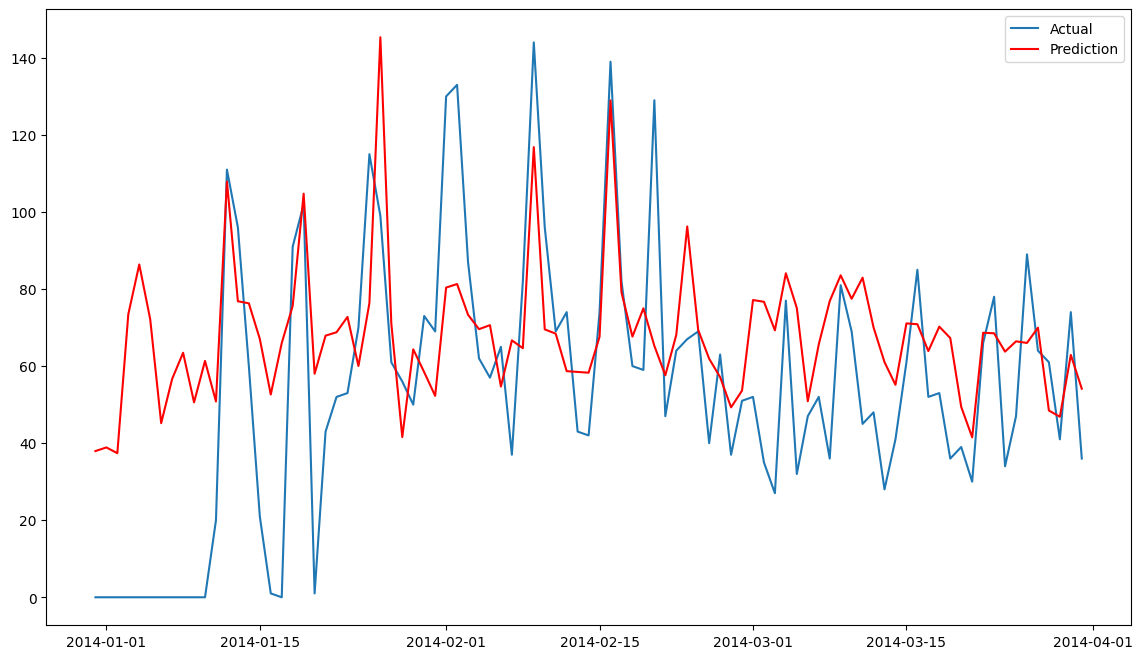

In [97]:
plt.figure(figsize=(14,8))
plt.plot(y_selected_test.index, y_selected_test.values, label = 'Actual')
plt.plot(y_selected_test.index, prediction_selected, label = 'Prediction', color='red')
plt.legend()
plt.show()

In [105]:
#export model as pickle file
import pickle

with open('/content/drive/My Drive/Data Analytics/retail_kaggle_data/' + 'trained_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

